# A Feed Forward Neural Network that Learns to Impute Missing Values

In [1]:
# Load libraries / packages / functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import seaborn as sns

# Change the graphics settings to display vector graphics for prettier outputs
from IPython import display
display.set_matplotlib_formats("svg")

# Self-defined functions in python scripts in this project
# (some imports are likely to be redundant)
from train_model import train_model
from FFNImputer import FFNImputer

/var/folders/wk/cgsrf1m50qx268ccx7b33rdr0000gn/T/ipykernel_28422/3316445509.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


In [2]:
# Get the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep = ";", header=0)
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
# In this case, the quality is not the ouctome, we want to predict NAs in sugar
## We drop the quality as including the outcome of interest in the imputation
## would be false (all theoretical as this is just a small capstone project...)
data.drop("quality", axis = 1, inplace = True)
y = data["residual sugar"]
X = data.drop("residual sugar", axis = 1)

In [4]:
# Split the data into train, test, and holdout set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_holdout, y_test, y_holdout = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [5]:
# Standardize the data
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_holdout = scaler.transform(X_holdout)

In [6]:
# Turn the datasets into torch.Tensors and TensorDatasets

## Training data
train_labels = torch.Tensor(np.array(y_train))[:, None].float()
train_data = torch.Tensor(X_train).float()
train_set = TensorDataset(train_data, train_labels)

## Testing data
test_labels = torch.Tensor(np.array(y_test))[:, None].float()
test_data = torch.Tensor(X_test).float()
test_set = TensorDataset(test_data, test_labels)

## Holdout data
holdout_labels = torch.Tensor(np.array(y_holdout))[:, None].float()
holdout_data = torch.Tensor(X_holdout).float()
holdout_set = TensorDataset(holdout_data, holdout_labels)

In [7]:
next(iter(holdout_set))

(tensor([-0.6520, -0.2263, -0.4733, -0.3944, -0.2790, -0.3844, -0.0399, -0.1406,
         -1.0314, -1.1576]),
 tensor([2.7000]))

In [8]:
# Set some important metaparameters here in one go
LEARNINGRATE = 0.001
BATCHSIZE = 16
EPOCHS = 100
BATCHNORMALIZE = True
DROPOUT = 0.0
DEPTH = 1
WIDTH = 32

In [9]:
# Create DataLoaders
train_loader = DataLoader(train_set,
                          batch_size = BATCHSIZE,
                          drop_last = True,
                          shuffle = True)
test_loader = DataLoader(test_set,
                         batch_size = test_set.tensors[0].shape[0])
holdout_loader = DataLoader(holdout_set,
                            batch_size = holdout_set.tensors[0].shape[0])

# Return some information on the training DataLoader
print(f"There are {len(train_loader)} batches in the train_loader, each with \
    {BATCHSIZE} samples.")

# Return some information on the test DataLoader
print(f"There is {len(test_loader)} batch in the test_loader, with \
    {len(next(iter(test_loader))[0])} samples.")


There are 79 batches in the train_loader, each with     16 samples.
There is 1 batch in the test_loader, with     160 samples.


In [10]:
# Create a model instance and test it
test_instance = FFNImputer()
X, y = next(iter(train_loader))
print("This is the input: ")
print(X[0])
print("This is the output: ")
test_instance(X)



This is the input: 
tensor([ 0.4504, -0.8960,  0.2433, -0.4958, -1.1520, -0.9614, -0.5466, -0.0757,
         0.8020,  0.7431])
This is the output: 


tensor([[-0.0020],
        [ 0.0683],
        [-0.0394],
        [-0.1120],
        [ 0.0104],
        [ 0.0429],
        [-0.0533],
        [-0.0091],
        [ 0.0309],
        [-0.0465],
        [-0.0071],
        [ 0.0094],
        [-0.0343],
        [ 0.0100],
        [ 0.0312],
        [-0.0141]], grad_fn=<AddmmBackward0>)

In [11]:
# Train the model using the train_model function
losses, model_instance = train_model(
    train_loader = train_loader,
    test_loader = test_loader,
    learning_rate = LEARNINGRATE,
    epochs = EPOCHS,
    batch_normalize = BATCHNORMALIZE,
    dropout = DROPOUT,
    width = WIDTH,
    depth = DEPTH
)

Going to train 100 epochs.
Training epoch 0
Training epoch 10
Training epoch 20
Training epoch 30
Training epoch 40
Training epoch 50
Training epoch 60
Training epoch 70
Training epoch 80
Training epoch 90
Training finished after 100 epochs,             last mean loss was 0.22767393290996552


Text(0.5, 1.0, 'Model loss')

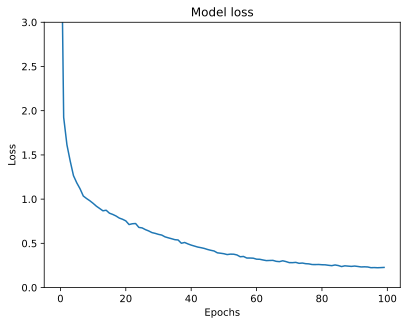

In [12]:
# Display results

plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0, 3])
plt.title("Model loss")

In [13]:
# Check the model on the holdout data
model_instance.eval()
X,y = next(iter(holdout_loader))
with torch.no_grad():
    y_hat = model_instance(X)
        
# Compare the following really long line of code to the training accuracy lines
#print(f"This is the holdout accuracy : {100 * torch.mean((y_hat == y).float())}")

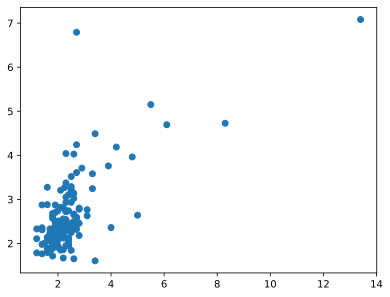

In [14]:
plt.plot(y, y_hat, "o");
